In [69]:
from sklearn.externals import joblib
from skimage.io import imread
from matplotlib import pyplot as plt
from pipeline import features
import numpy as np
from torchvision import models
from torchvision.transforms import Compose
from dataset.normalization import get_normalization_transform
from util.augmentation import NumpyToTensor
from pathlib import Path
from dataset import FungusDataset

In [70]:
# you may need to adjust this accroding to your setup
model_path = './best_model.pkl'
patch_path = './patch.png'
normalization_params_path = Path('.')

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('fisher_vector', FisherVectorTransformer(gmm_clusters_number=10, gmm_samples_number=10000,
            init_mode='kmeans')), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=24,
       param_grid=[{'fisher_vector__gmm_samples_number': [10000], 'fisher_vector__gmm_clusters_number': [5, 10, 20, 50], 'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['linear']}, {'fisher_vector__gmm_samples_number': [10000], 'fisher_vector__gmm_clusters_number': [5, 10, 20, 50], 'svc__C': [1, 10, 100, 1000], 'svc__gamma': [0.001, 0.0001], 'svc__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


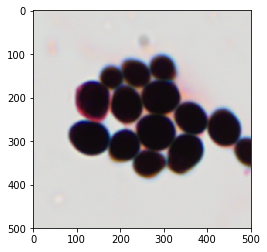

In [71]:
# load and inspect model and image patch
model = joblib.load(model_path)
print(model)
patch = imread(patch_path)
plt.imshow(patch)

In [72]:
# normalize image
transform = [
    NumpyToTensor(),
    get_normalization_transform(normalization_params_path),
]
transform = Compose(transform)
patch = transform(patch)

In [73]:
# extract features from patch
device = features.get_cuda()
patch = patch.unsqueeze(0)
print(patch.shape)
# best model uses alexnet, so let's load it
extractor = models.alexnet(pretrained=True).features.eval().to(device)
features_matrix = features.extract_features(patch, device, extractor)
features_matrix = features_matrix.detach().numpy()
print(features_matrix.shape)

torch.Size([1, 3, 500, 500])
(1, 196, 256)


In [74]:
# predict classification
result = model.predict(features_matrix)
FungusDataset.NUMBER_TO_FUNGUS[result[0]]

'BG'